# 3. Building a Model with PyMC

Let's build our first `PyMC` model using a motivating simple linear regression example. We won't focus much on the details of linear regression, because it is covered later in [Unit 7.10](https://areding.github.io/6420-pymc/unit7/Unit7-regression.html), but more on the modeling structure with `PyMC` as well as viewing the DAG structure of the model.

This is a short and simplified tutorial on the basic building blocks of a PyMC model. The [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview) on PyMC's website covers these concepts more exhaustively.

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

## Generate Data

Data comes from a canonical linear regression problem with 5 data points. The goal in linear regression is to find a best-fit line through this data. Let's define the `X` and `y` data, and plot it.

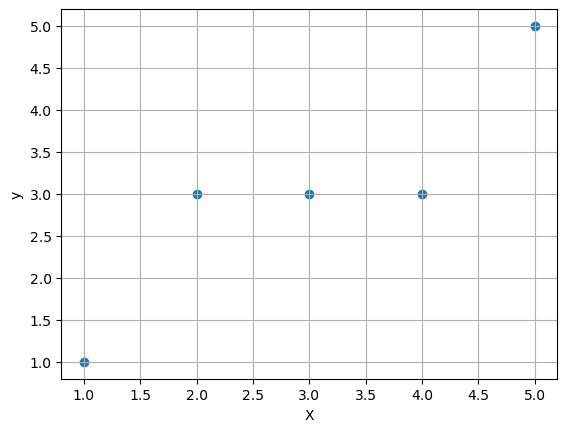

In [2]:
# sample data
X = np.array([1,2,3,4,5])
y = np.array([1,3,3,3,5])

# plot it
plt.scatter(X,y)
plt.xlabel('X')
plt.ylabel('y')
plt.grid()
plt.show()

## Model Specification

This linear regression model is specified by:  

$$ \begin{align*}
y_{i} & \sim N(\mu,\sigma^2) && \text{likelihood}\\ \\
\mu & = \alpha + \beta x && \text{deterministic - regression equation}\\
\alpha & \sim  N(0,1000) && \text{prior: } \beta_0\\
\beta & \sim  N(0,1000) && \text{prior: } \beta_1\\
\tau & \sim  Ga(.001,.001) && \text{prior: } \tau\\
\sigma & =  1/\sqrt{\tau} && \text{deterministic - } \tau \text{ to } \sigma\\
\end{align*}$$

We specify the model in PyMC below, almost matching the specification above line-by-line:

In [3]:
coef_sigma = 1000**.5

with pm.Model() as m:
    
    # data containers
    X_data = pm.Data("X", X)
    y_data = pm.Data("y", y)

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=coef_sigma)
    beta = pm.Normal("beta", mu=0, sigma=coef_sigma)
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)

    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    # regression
    mu = pm.Deterministic("mu",alpha + pm.math.dot(X_data, beta))

    # likelihood
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y_data, shape=X_data.shape[0])

Here's what's specified in the code block above:

**Data contaniners** - `X` and `y` data are stored in the data containers `X_data` and `y_data`. This isn't always necessary and we could access the original `X` and `y` variables within the model, but data containers are needed in certain models, as we will see in upcoming units. Also, data containers allow the data to be visualized in the GraphViz model structure below.

**Priors** - three priors are defined (`alpha`, `beta`, and `tau`) with *stochastic* variables. `alpha` and `beta` are the intercept and slope in the regression model, and assumed to follow fairly non-informative Normal distributions. `tau` is the precision of the error, that is the error between the model's predicted y and the true y values. 

**Deterministic Variables** - After `tau`, we see `sigma` defined as a *deterministic* variable, which is used to track variables that are completely defined by their parent's values. We can observe deterministic variables' samples after the model is run. `mu` is another deterministic variable for the regression equation. We could run the model with or without `sigma` and `mu` defined with `pm.Deterministic`, the difference is we can observe the samples afterword. Also, deterministic variables can be seen in the GraphViz model structure below.

**Likelihood** - The likelihood is defined in a similar way to a prior, except the `observed` argument is used. This is a special case of a stochastic variable, called an *observed stochastic*. The `shape` argument is also helpful (but not necessary), which is the number of data points in this case.

**pm.math functions** - In the `sigma` and `mu` variables, we are using `pm.math.sqrt` and `pm.math.dot`. Whenever possible, `PyMC` math functions should be used rather than `numpy`, because the model is compiled with `PyMC` / `PyTensor`, and is more efficient that way.

## Model Graph
Now we can look at the model structure using GraphViz. The shape/variable type representation is:

* Grey rectangles - Data containers
* White circles - Stochastic variables
* White rectangles - Deterministic variables
* Grey circle - Observed stochastic (likelihood)

We also see a larger rectangle encloses the data, mu, and likelihood variables, with the number '5' in its lower-right corner. This is called [plate notation](https://en.wikipedia.org/wiki/Plate_notation), which represents the 5 data points.

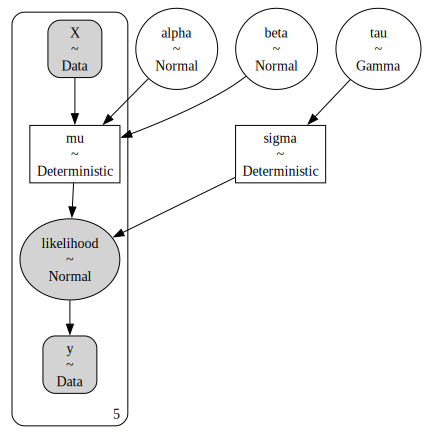

In [4]:
pm.model_to_graphviz(m)

## Sample from the Model

The next step is to sample from the model. We collect 5000 draws from 4 separate MCMC chains in the line below. `target_accept` is a parameter we may adjust to account for troubleshoot divergences.

In [5]:
with m:    
    trace = pm.sample(draws=5000, chains=4, target_accept=0.98)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


## Posterior Analysis

The `Arviz` library is a platform-agnostic tool for posterior analysis, using the `trace` object containing the MCMC samples. We can take a look at statistics like mean, standard deviation, and 95% HDI using the `summary` function. The last 5 columns in the summary table are diagnostic tools. The most common diagnostic used in [rhat](https://python.arviz.org/en/stable/api/generated/arviz.rhat.html). rhat values of 1.01 or greater indicate issues with model convergence.

In [6]:
az.summary(trace,hdi_prob=.95,var_names=['alpha','beta','sigma'])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.540,1.364,-1.921,3.023,0.029,0.075,3560.0,2710.0,1.0
beta,0.818,0.413,0.064,1.574,0.009,0.023,3523.0,2425.0,1.0
sigma,1.041,0.778,0.319,2.280,0.016,0.041,2953.0,2874.0,1.0


`Arviz` also has many vizualization capabilities. The `plot_trace` function below shows density and trace plots of the specified variables.

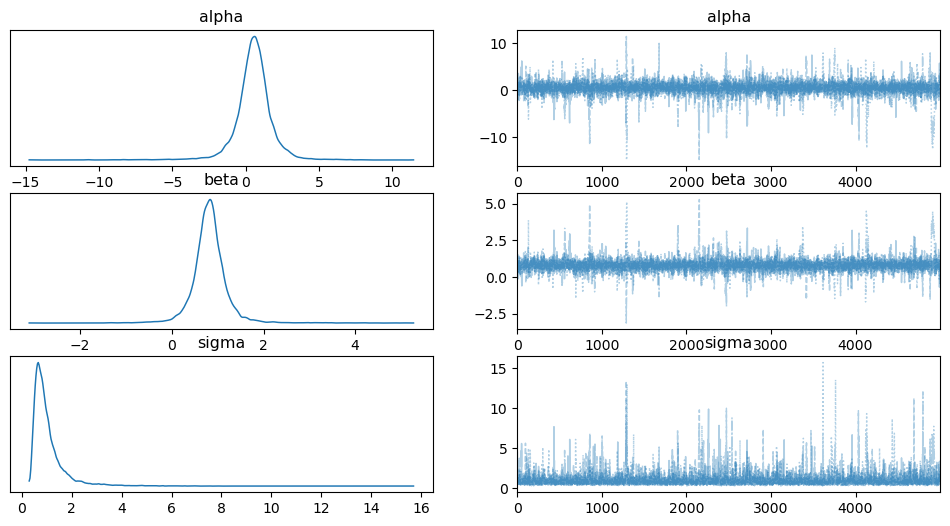

In [7]:
az.plot_trace(trace, var_names=['alpha','beta','sigma'],combined=True)
plt.show()

## Frequentist Regression Comparison

Let's apply a frequentist regression to the data to double check our Bayesian results. The `statsmodels` package is used below, which is nice because it has a straighforward summary function that prints out several statistics including the 95% confidence intervals of the coefficients. 

We can see the frequentist model gives similar coefficients and confidence intervals as the Bayesian model. In general, if we use non-informative priors in a Bayesian model, the results should approach the frequentist version.

In [8]:
import statsmodels.api as sm

X_aug = sm.add_constant(X, prepend=False)
mod = sm.OLS(y, X_aug)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     12.00
Date:                Wed, 11 Jun 2025   Prob (F-statistic):             0.0405
Time:                        18:43:47   Log-Likelihood:                -4.2461
No. Observations:                   5   AIC:                             12.49
Df Residuals:                       3   BIC:                             11.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8000      0.231      3.464      0.0

/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [9]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Wed Jun 11 2025

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.2.0

numpy      : 2.2.6
arviz      : 0.21.0
matplotlib : 3.10.3
statsmodels: 0.14.4
pymc       : 5.22.0

